# Class 15: Machine Learning 2 — Building up to Graph Convolutional Networks

## Today's Goals
1. Think about how graph neural networks operate at a high level.
2. Understand what the building blocks of a graph neural network are.
3. Play with a graph neural network's hyperparameters.

## Backpropagation (by request):
At a very high level, backpropagation is how we adjust our weights, going back from the output layer (and our loss function) all the way back to the weights from the input layer. 

It involves computing a bunch of partial derivatives (gradients) and adjusting our weights/biases (the parameters we're learning in our neural network) according to the relationship between the gradients and the loss. 

### What ingredients do we need to do backpropagation?

First, we need a loss function. Our loss function (or cost function) needs to be differentiable with respect to the weights and biases we use in the network. Our loss also has to be expressed as a function of the input and our weights and biases. For example, let's look at a toy example with one hidden layer and a mean squared error (MSE) loss function. 

![feed-forward NN](https://miro.medium.com/v2/resize:fit:3200/1*ycDUAMaxDYaHx7xl9pqEjg.png)

The simplified output $g(\vec{x}) of our neural network with input $\vec{x}$, given weight matrices $W^{(1)}$ and $W^{(2)}$ and generic activation functions $\sigma^{(1)}$ and $\sigma^{(2)}$, is

$$g(x) = \sigma^{(2)}(W^{(2)} \sigma^{(1)}(W^{(1)} \vec{x}))$$

Our loss function, with ground truth $\vec{z}$, is $\lvert \lvert g(\vec{x}) - \vec{z} \rvert \rvert$. In the generalized sense, we can use a generic loss function $C(g(\vec{x}), \vec{z})$. 

Next, we need partial derivatives and the chain rule!

This is how backpropagation adjusts the weights -- we compute the partial derivative of our cost function $C$ with respect to one weight from node $i$ to node $j$ in the $2^{nd}$ matrix of weights:

$$\frac{\delta C}{\delta w^{(2)}_{ij}} = \frac{\delta C}{\delta y_j} \frac{\delta y_j}{\delta w^{(2)}_{ij}}$$

Here, $y_j$ is the $j^{th}$ output of our network (in the output layer).

$$y_j = \sigma^{(2)}(\sum_{i}w^{(2)}_{ij} * h_i)$$

In other words, we're passing the dot product of row $j$ of $W^{(2)}$ and $\vec{h}$, our hidden layer's output, through a sigmoid function. Let's call $\sum_{i}w^{(2)}_{ij} * h_i$ $o_j$, and let's expand our partial derivative expression using the chain rule once more. 

$$\frac{\delta C}{\delta w^{(2)}_{ij}} = \frac{\delta C}{\delta y_j} \frac{\delta y_j}{o_j} \frac{o_j}{\delta w^{(2)}_{ij}}$$

What are we doing here? We're tracing how our specific weight $w^{(2)}_{ij}$ affects our computed loss for a particular input (or batch of inputs). 

We know that $\frac{\delta y_j}{o_j}$ is the partial derivative of the activation function $\sigma^{(2)}$. 

Additionally, we know that $\frac{o_j}{\delta w^{(2)}_{ij}}$ is 

$$\frac{\delta}{\delta w^{(2)}_{ij}}\sum_{k}w^{(2)}_{kj}h_k$$

Only one term in this sum relies on $w^{(2)}_{ij}$ -- that's $w^{(2)}_{ij} h_i$. This means this part of our partial derivative reduces to  

$$\frac{o_j}{\delta w^{(2)}_{ij}} = h_i$$

Now let's look at $\frac{\delta y_j}{h_j}$. Let's say we're using a sigmoid activation function; in this case, this part of our partial derivative is 

$$\frac{\delta}{\delta h_j}\sigma(h_j) = \sigma(h_j) (1 - \sigma(h_j)) = y_j * (1 - y_j)$$

If we're using MSE for the loss function $C$ and $\vec{z}$ is our ground truth answer, 

$$\frac{\delta C}{\delta y_j} = 2 (z_j - y_j)$$.

Therefore, the gradient of our loss with respect to $w^{(2)}_{ij}$ is 

$$\frac{\delta C}{\delta w^{(2)}_{ij}} = 2 (z_j - y_j) * y_j * (1 - y_j) * h_i$$.

### Moving right along/TL;DR (For those who hate math!!)
We take partial derivatives with the chain rule to figure out how much our loss function changes with respect to a particular parameter (like a weight or bias) in the neural network. 

Then we can change that specific weight with this information. We usually have a learning rate $\eta$ (or an optimizer that governs the learning rate, which is fancier) that tells us how much to change a weight/bias with respect to our computed gradient.

$$\delta w^{(2)}_{ij} = \eta \frac{\delta C}{\delta w^{(2)}_{ij}}$$.

We don't want to update our parameters too much based on any one example, which is why the learning rate tends to be pretty small (much less than 1) and optimizers will lower the learning rate as training goes on and the model gets better at its task.

Let's review how backpropagation works by watching [this video](https://www.youtube.com/watch?v=GlcnxUlrtek&list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU&index=4). 

## What do GNNs do?
Bottom line: GNNs learn weight matrices that transform node attributes or embeddings. They aggregate information about a node's neighborhood in order to make the next round of node embeddings. These embeddings can then be used for interesting downtream tasks.

### Applications

**INTERACTIVE MOMENT:**
Let's think of some applications for GNNs. What would you use a GNN to do?

----------------------
Examples: protein-protein interaction prediction, fraud detection, or social network recommendations.

### Sidebar: graph isomorphism
Graph isomorphism occurs when you have two graph of the same size, one with one set $G$ and one with node set $H$. If you can create a one-to-one mapping $f$ from $G$ to $H$ such every node in $G$ has exactly one corresponding node in $H$ that is indicated by $f(G)$, and two nodes in $f(G)$ are connected if and only if they are also connected in $H$, then you can say that $G$ and $H$ are isomorphic. Basically, if you can rename everyone in a graph with a unique name of an individual in another graph and the structure stays the same, you have two isomorphic graphs. This is important because we want graph neural networks to obey isomorphism. If two graphs are isomorphic and their nodes have the same features, their embeddings should be the same. 

## How do we learn about nodes' neighborhoods?
Nodes in networks notably have neighborhoods of variable size, but we want to represent all nodes with vectors of the same size. So an approach like word2vec might not work if we're trying to aggregate information about a node's neighborhood. Recall that we concatenated one-hot vectors representing the $k$ words surrounding a word in a sentence to form a word's context when training word2vec -- but how do we know which $k$ nodes ought to form the "context" of a node with far more than $k$ neighbors? 

### enter...permutation-invariant functions
#### What is a permutation-invariant function?
Permutation-invariant functions take in multiple inputs (say, a list of inputs), and they produce the same output regardless of the order in which the inputs are given. So if $f(x, y, z) = f(y, z, x)$, and so on for all orderings of $x, y, z$, then $f$ is permutation-invariant.

#### Why do we care about permutation-invariance?
Permutation-invariance is really useful for incorporating information about a node's neighborhood in a graph. For example, operations like the mean, maximum, sum, and minimum are all permutation-invariant. We can put in as many nodes' attributes as we'd like, and our output will maintain the same dimensionality. It will also be insensitive to how we order the inputs, so we don't have to worry about how to order data that doesn't come with inherent order. 

### The three core functionalities in most GNNs
#### AGGREGATE
In order to pass information through a GNN, we first gather up our information about a node's neighborhood -- this might be a set of node embeddings from a previous layer or the nodes' raw feature vectors. Then, we pass this set of vectors through a permutation-invariant function like MEAN. This aggregates our information about the node's neighborhood into a vector of fixed length. 

#### COMBINE
Next, we need to update our node's embedding. We might concatenate our neighborhood vector with our previous node embedding (or feature vector). Some GNNs will include a node in its own neighborhood during aggregation, thereby bypassing the COMBINE step. This gives us the embedding for the node that will be passed to the next layer. 

#### READOUT
Often we need something more than just node embeddings -- we might need information about the whole graph, in which case we'll need to apply a permutation-invariant function to our entire set of node embeddings produced by our last GNN layer, or we might need to pass individual node embeddings through some linear neural network layers to classify nodes, for example. 

## Tidbits
### The Weisfeiler-Lehman Test and Isomorphism
The Weisfeiler-Lehman test (W-L test) is a test of graph isomorphism, which we talked about before. It iteratively assigns colors to nodes in a graph, then updates a node's color by hashing the colors of its neighbors. Some specially formulated GNNs are at least as powerful as the W-L test, although many GNNs that aren't specially formulated for this application can't distinguish graphs that the W-L test *can* distinguish between. For more on this topic, check out this [paper](https://arxiv.org/abs/1810.00826) by Xu et al. or a [cool extension](https://cs.stanford.edu/people/jure/pubs/idgnn-aaai21.pdf) on the idea by You et al.

### Challenges with GNNs
GNNs get computationally intensive pretty fast, particularly with new transformer-based or attention-based models. They also don't do great when passing long-range signals around the network -- while in theory you could have many, many layers that bring in signals from as many hops away as you have layers, in practice, this causes **oversquashing** and **oversmoothing**. **Oversmoothing** is when all node representations start to resemble each other (see [this paper](https://arxiv.org/abs/1909.03211) for more details), and **oversquashing** happens when you try to fit enormous amounts of information into fixed-length vectors (see [this paper](https://arxiv.org/abs/2006.05205) to learn more). That's why GNNs typically don't have very many layers, although each layer can be quite fancy.

## GCNs (as an example of a GNN)

Material in this section relies heavily on Maxime Labonne's [blog post](https://towardsdatascience.com/graph-convolutional-networks-introduction-to-gnns-24b3f60d6c95) in *Towards Data Science* and Thomas Kipf's [blog post](https://tkipf.github.io/graph-convolutional-networks/) on his GitHub website. 

A [GCN](https://arxiv.org/pdf/1609.02907) (Kipf & Welling, 2017) is a type of graph neural network that aggregates nodes' neighborhoods in a clever way. It uses insights from image processing to perform the AGGREGATE functionality. It scales nicely (as far as GNNs go), learns about graph structure **and** node features, and performs quite well on graphs with node features & labels. 

### What is a convolution in image processing world?
A **convolution matrix**, or **kernel**, is used in image processing to blur, enhance, sharpen, or detect edges in an image. It's a small matrix (relative to the size of the image) that is applied to each pixel in the image **and its neighbors within a certain distance**. 

The generic equation for a kernel is this, where $\omega$ is the kernel matrix, $a$ and $b$ indicate the dimensions of the kernel, and $f(x, y)$ is the $(x, y)^{th}$ pixel of the image:

$$g(x, y) = \sum_{i=-a}^{a} \sum^{b}_{j=-b} \omega(i, j) f(x-i, y-j)$$

Here, $g(x, y)$ is the $(x, y)^{th}$ pixel of the output image.

Here's a visual example of a convolution matrix being applied to a single pixel (from [this article](https://www.researchgate.net/publication/332190148_Best_Practice_Guide_-_Deep_Learning)):
![](https://www.researchgate.net/profile/Volker-Weinberg/publication/332190148/figure/fig2/AS:743933420249088@1554378957080/Schematic-illustration-of-a-convolutional-operation-The-convolutional-kernel-shifts-over.ppm)

### Graph Convolutions
You might say, cool, that's neat, but how does that apply to graphs? First of all, graph neighborhoods are not rectangular in shape, and graphs notably have degree *distributions* - not every node has the same number of neighbors (far from it)! 

Let's tackle what happens in GCNs at the node level first. We'll look at how we create our first embedding for node $i$, $h_{i}^{(1)}$. 

We know we need to merge our node features with those of our neighbors, so we define a node $i$'s neighborhood here as $i$'s neighbors plus $i$ itself. We'll denote this as $\tilde{N_i}$.

In the simplest case, we could create a weight matrix $W_i$ and multiply each node $j$'s features $x_j$ by $W_i$, then sum them:

$$h_{i}^{(1)} = \sum_{j \in \tilde{N_i}} W^{(1)} x_j$$

This seems neat, but there's a small problem.

**INTERACTIVE MOMENT**: Nodes in graphs notably don't all have the same degree. What's going to happen to the vectors of high-degree nodes as compared to those of low-degree nodes right now? How might we fix this?

--------------------

Spoiler alert: we're going to divide by $k_i$, the degree of node $i$. This keeps vector magnitudes around the same-ish size. 

$$h_{i}^{(1)} = \frac{1}{k_i}\sum_{j \in \tilde{N_i}} W^{(1)} x_j$$

However, there's one more improvement we can make. Kipf and Welling noticed that features from high-degree nodes tended to propagate through the network more easily than those from low-degree nodes. They therefore up-weight the lower-degree nodes' contributions in the following way:

$$h_{i}^{(1)} = \sum_{j \in \tilde{N_i}} \frac{1}{\sqrt{k_i}}\frac{1}{\sqrt{k_j}} W^{(1)} x_j$$

**INTERACTIVE MOMENT**: Why does this work? 

#### Matrix Formulation
There's also a neat way we can formulate this as a matrix multiplication. Here, $\hat{A}$ is the adjacency matrix with self-loops added, and $\hat{D}$ is $\hat{A}$'s degree matrix (i.e. $A + I$). $H^{(l)}$ is the matrix of node embeddings coming into layer $l$, and $W^{(l)}$ is the weight matrix of layer $l$:

$$f(H^{(l)}, A) = \sigma(\hat{D}^{-\frac{1}{2}} \hat{A} \hat{D}^{-\frac{1}{2}} H^{(l)} W^{(l)})$$. 

Now we're going to play with a GCN instance. First, let's try training the neural network on the [Cora dataset](https://paperswithcode.com/dataset/cora), which is a citation network with 7 classes of publication. There are 2708 publications and 5429 citation links between them. We're going to train a 2-layer GCN on this dataset and see how well it performs on held-out validation data. 

In [2]:
from torch.nn import Linear
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import CitationFull
import torch_geometric

# # loading the dataset
dataset = torch_geometric.datasets.CitationFull('data/', name='Cora')

In [3]:
dataset.num_classes

70

In [4]:
dataset[0].x.shape

torch.Size([19793, 8710])

In [16]:
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import RandomNodeSplit

losses = []
accuracies = []
# checking if the GPU is available; else use the CPU. 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) # yell if you don't see 'cuda' here!

hidden_dims = [64, 32, 16]  # Define a list of dimensions for each hidden layer

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        # Define a list to hold all GCN layers
        self.gcn_layers = torch.nn.ModuleList()
        # Create each layer
        prev_dim = input_dim
        for dim in hidden_dims:
            self.gcn_layers.append(GCNConv(prev_dim, dim))
            prev_dim = dim
        # Final output layer
        self.out = Linear(prev_dim, output_dim)
    
    def forward(self, x, edge_index):
        for gcn_layer in self.gcn_layers:
            x = gcn_layer(x, edge_index).relu()
        z = self.out(x)
        return x, z


splits = RandomNodeSplit(split='train_rest', num_val=0.15, num_test=0.15)(dataset.data)
# this lets us make a mask on our dataset 
# such that we're only training the model on a subset of nodes.
# we have a validation set that we look at each epoch to track our accuracy
# as well as a test set that we can use to look at our performance at the end of training.

model = GCN(input_dim=dataset.num_features, hidden_dims=hidden_dims, output_dim=dataset.num_classes)

model.to(device) # puts it on the GPU

criterion = torch.nn.CrossEntropyLoss() 
# cross-entropy loss tells us how wrong given our final output 

optimizer = torch.optim.Adam(model.parameters(), lr=0.02) 
# you can mess with the learning rate or choice of optimizer
loader = DataLoader(dataset)

all_embeddings = []  # Initialize a list to store embeddings for each epoch

for epoch in range(1, 101):
    # Training step
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        h2, z = model(batch.x.to(device), batch.edge_index.to(device))
        loss = criterion(z[splits.train_mask], batch.y.to(device)[splits.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Evaluation step (collect embeddings here)
    model.eval()
    with torch.no_grad():
        # Get embeddings for all nodes in the dataset
        h2, val_z = model(dataset.x.to(device), dataset.edge_index.to(device))
        # Optionally, only store embeddings for nodes in the validation set
        val_embeddings = h2[splits.val_mask]
        all_embeddings.append(val_embeddings.cpu().numpy())  # Store for each epoch

    # Print or store additional metrics if needed
    val_z = val_z[splits.val_mask]
    ans = val_z.argmax(dim=1)
    ys = dataset.y.to(device)[splits.val_mask]
    accuracy = torch.mean(torch.eq(ans, ys).float())
    loss = total_loss / len(loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')
# for epoch in range(1, 101):
#     model.train() # keeps track of gradients; this is memory-intensive.
#     total_loss = 0 # keep track of loss
#     tot_accuracy = 0 # keep track of 
#     for batch in loader:
#         optimizer.zero_grad() 
#         # zero the gradient so we aren't accumulating them unnecessarily
#         h2, z = model(batch.x.to(device), batch.edge_index.to(device)) 
#         # make sure we're putting our data on GPU
#         loss = criterion(z[splits.train_mask], batch.y.to(device)[splits.train_mask])
#         # only do backpropagation based on nodes in the train set.
#         loss.backward()
#         # this is the backpropagation step.
#         optimizer.step()
#         # optimizers control how backpropagation goes. T
#         # The fancier ones, like Adam, can adjust the learning rate 
#         # dynamically depending on the magnitude of the gradients.
#         # AdaGrad can change the learning rate for each rate, so it's really fancy.
#         total_loss += loss.item() # keep track of our total loss (cross-entropy)
#     model.eval() # put the model in eval mode - don't accumulate gradients.
#     # this saves memory!
#     val_h, val_z = model(dataset.x.to(device), dataset.edge_index.to(device)) 
#     # run our dataset through the model
#     val_z = val_z[splits.val_mask]
#     # look only at the validation set's vectors
#     ans = val_z.argmax(dim=1) 
#     # what predictions did we get for the classes?
#     ys = batch.y.to(device)[splits.val_mask]
#     tot_accuracy += torch.mean(torch.eq(ans, ys).float()) # how often were we right?
#     loss = total_loss / len(loader)
#     accuracy = tot_accuracy / len(loader)
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')
    losses.append(loss)
    accuracies.append(accuracy)

cpu


/opt/anaconda3/envs/phd2024/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch: 001, Loss: 4.2467, Accuracy: 0.0394
Epoch: 002, Loss: 4.1846, Accuracy: 0.0701
Epoch: 003, Loss: 4.0603, Accuracy: 0.0694
Epoch: 004, Loss: 3.9004, Accuracy: 0.0983
Epoch: 005, Loss: 3.7270, Accuracy: 0.1263
Epoch: 006, Loss: 3.5675, Accuracy: 0.1687
Epoch: 007, Loss: 3.4112, Accuracy: 0.2004
Epoch: 008, Loss: 3.2685, Accuracy: 0.2573
Epoch: 009, Loss: 3.0722, Accuracy: 0.2785
Epoch: 010, Loss: 2.9031, Accuracy: 0.2977
Epoch: 011, Loss: 2.7422, Accuracy: 0.3254
Epoch: 012, Loss: 2.5719, Accuracy: 0.3803
Epoch: 013, Loss: 2.4384, Accuracy: 0.4432
Epoch: 014, Loss: 2.2732, Accuracy: 0.4483
Epoch: 015, Loss: 2.1798, Accuracy: 0.4884
Epoch: 016, Loss: 2.0338, Accuracy: 0.5167
Epoch: 017, Loss: 1.9559, Accuracy: 0.5237
Epoch: 018, Loss: 1.8424, Accuracy: 0.5301
Epoch: 019, Loss: 1.7962, Accuracy: 0.5362
Epoch: 020, Loss: 1.7457, Accuracy: 0.5726
Epoch: 021, Loss: 1.6016, Accuracy: 0.5635
Epoch: 022, Loss: 1.5623, Accuracy: 0.5850
Epoch: 023, Loss: 1.5063, Accuracy: 0.6063
Epoch: 024,

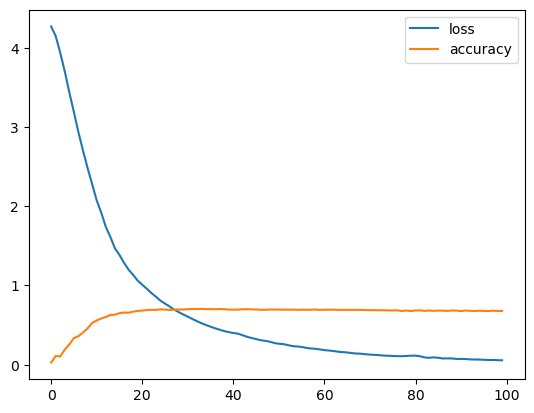

In [17]:
import matplotlib.pyplot as plt
plt.plot(losses, label='loss')
plt.plot(accuracies, label='accuracy')
plt.legend()

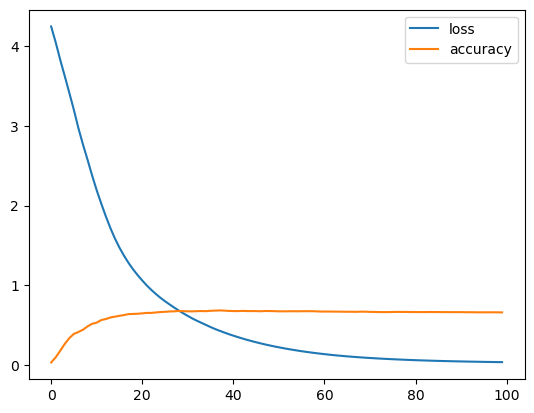

In [29]:
import matplotlib.pyplot as plt
plt.plot(losses, label='loss')
plt.plot(accuracies, label='accuracy')
plt.legend()

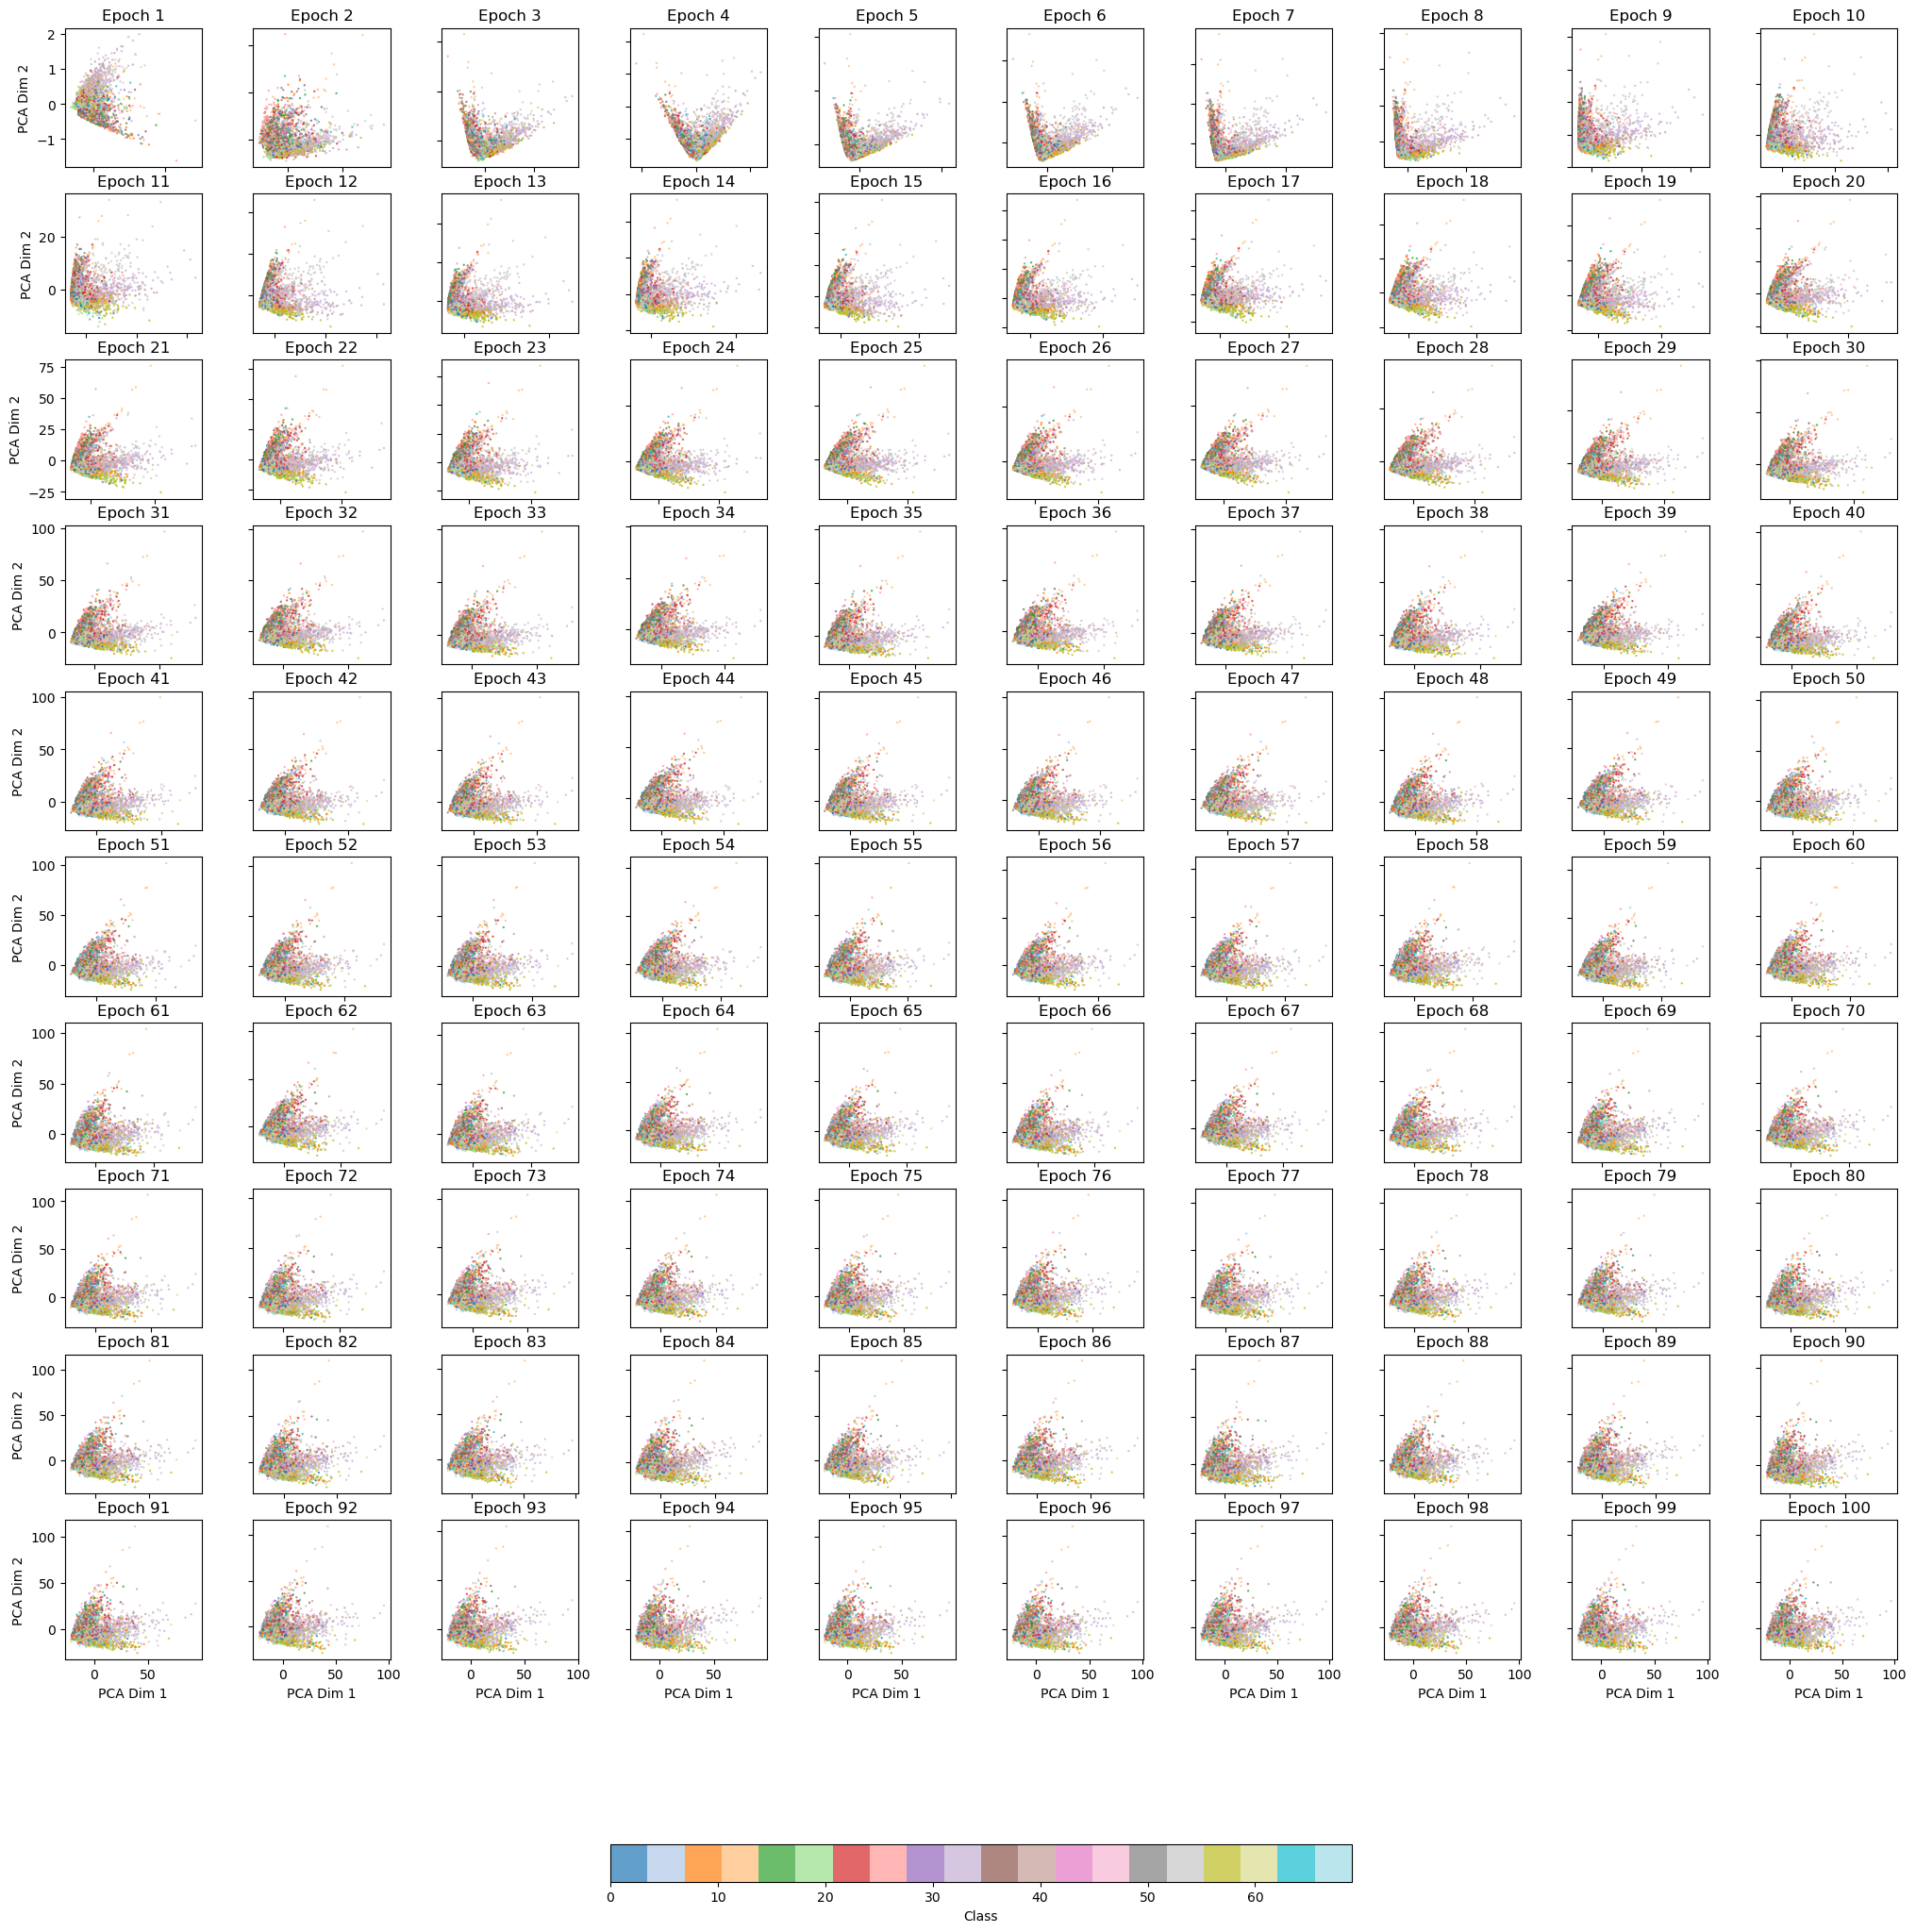

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Number of epochs (assuming 100 for a 10x10 grid)
num_epochs = 100

# Initialize a 10x10 subplot grid
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout(pad=0.2)  # Adjust padding between subplots

# Plot embeddings for each epoch on a different subplot
for epoch, embeddings in enumerate(all_embeddings):
    # Perform PCA to reduce embeddings to 2 dimensions for visualization
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    # Determine subplot position
    ax = axes[epoch // 10, epoch % 10]
    scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                         c=dataset.y[splits.val_mask], cmap='tab20', alpha=0.7, s = 0.5)
    
    ax.set_title(f'Epoch {epoch + 1}')
    ax.set_xlabel('PCA Dim 1')
    ax.set_ylabel('PCA Dim 2')
    ax.label_outer()  # Hide x and y labels on inner subplots for cleaner appearance

# Add a single colorbar for the entire figure
fig.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1, label='Class')

plt.show()


In [20]:
15 % 10

5

In [24]:
help(TSNE)

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [12]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "4"

100it [07:10,  4.31s/it]


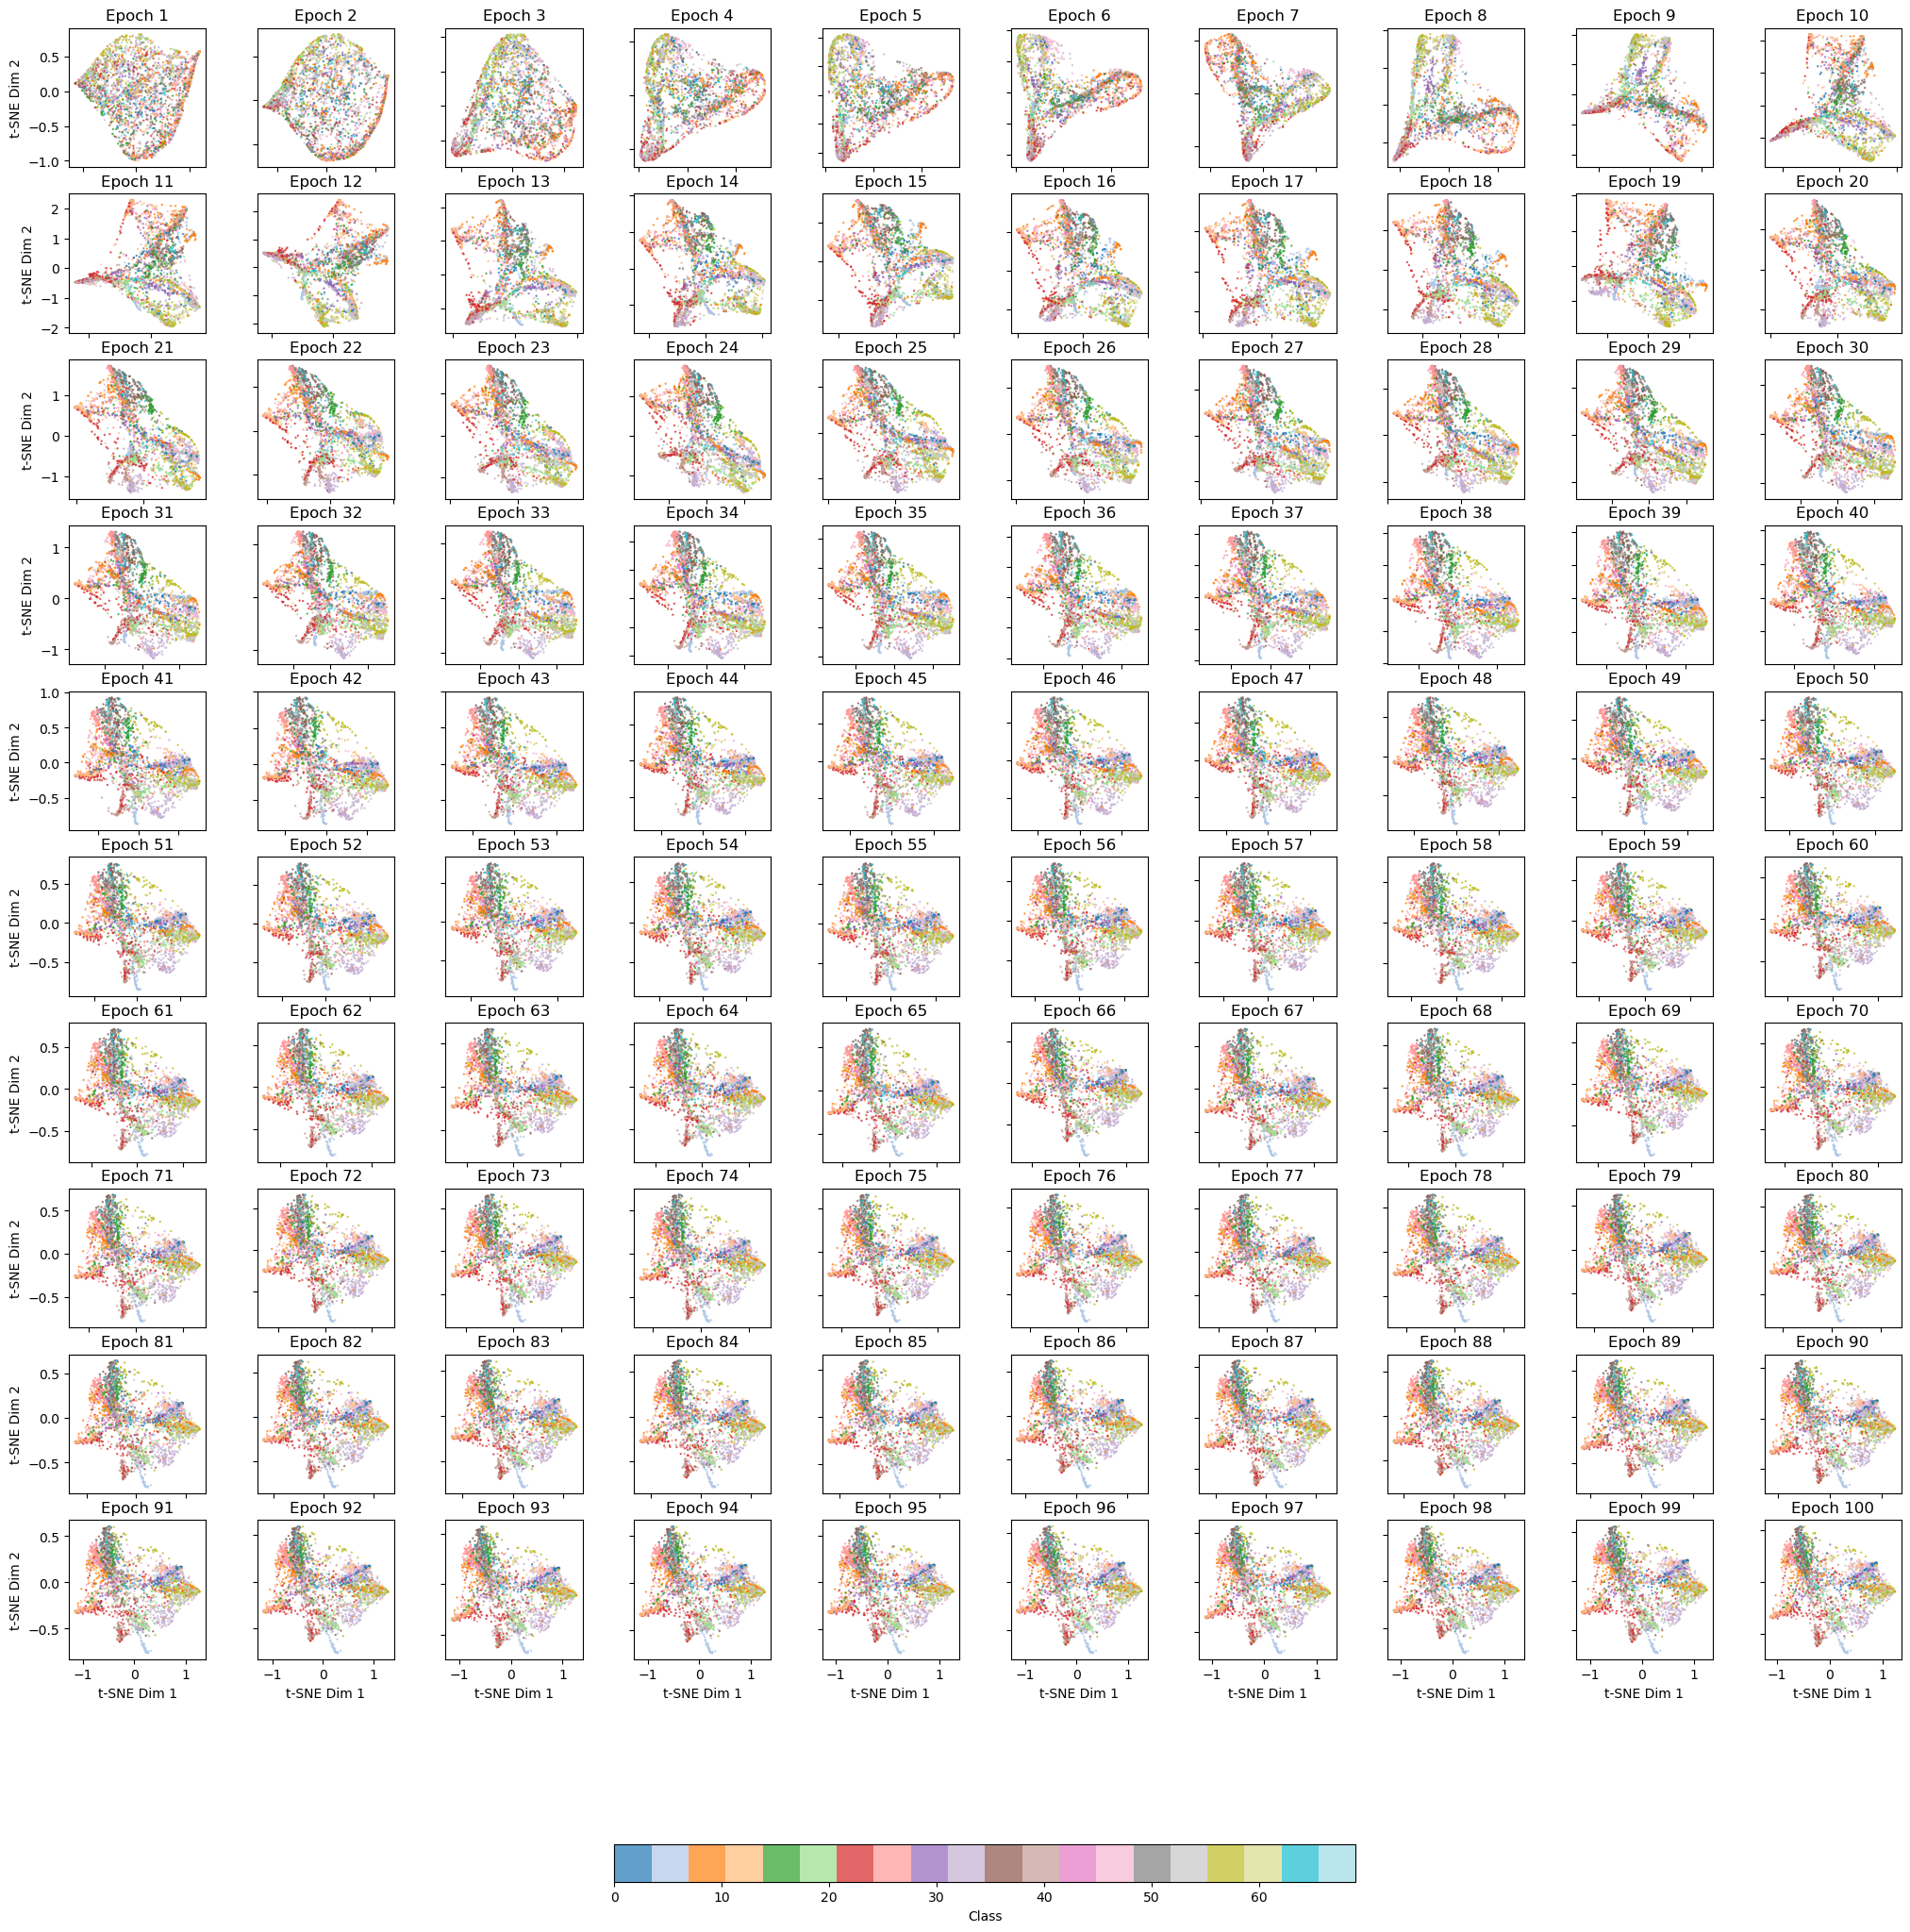

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Number of epochs (assuming 100 for a 10x10 grid)
num_epochs = 100

k = 0
rows, cols = 10, 10
indices = list(itertools.product(range(rows), range(cols)))
# Initialize a 10x10 subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
fig.tight_layout(pad=0.2)  # Adjust padding between subplots

# Plot embeddings for each epoch on a different subplot
for epoch, embeddings in tqdm(enumerate(all_embeddings)):

    if epoch % 1 == 0:
        # Perform t-SNE to reduce embeddings to 2 dimensions for visualization
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=250)  # Adjust perplexity based on dataset size
        reduced_embeddings = tsne.fit_transform(embeddings)
        # Determine subplot position
        x, y = indices[k]
        ax = axes[x, y]
        scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                            c=dataset.y[splits.val_mask], cmap='tab20', alpha=0.7, s=0.5)
        
        ax.set_title(f'Epoch {epoch + 1}')
        ax.set_xlabel('t-SNE Dim 1')
        ax.set_ylabel('t-SNE Dim 2')
        ax.label_outer()  # Hide x and y labels on inner subplots for cleaner appearance
        k+=1

# Add a single colorbar for the entire figure
fig.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1, label='Class')
plt.savefig('/Users/nima/Desktop/PhD/PHYS 7332/assignment03/figs/tsne_embeddings.pdf', bbox_inches='tight')
plt.savefig('/Users/nima/Desktop/PhD/PHYS 7332/assignment03/figs/tsne_embeddings.png', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from tqdm import tqdm  # Progress bar

# Dummy data for demonstration
# Replace all_embeddings and dataset.y[splits.val_mask] with actual data


# Initialize the figure and single subplot
fig, ax = plt.subplots(figsize=(8, 8))

# Set up color map and other plot attributes
scatter = ax.scatter([], [], c=[], cmap='tab20', alpha=0.7, s=0.5)
colorbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Class')

# Function to initialize the animation
def init():
    ax.clear()
    ax.set_title("t-SNE Embeddings Over Epochs")
    ax.set_xlabel("t-SNE Dim 1")
    ax.set_ylabel("t-SNE Dim 2")
    return scatter,

# Function to update each frame of the animation
def update(epoch):
    ax.clear()  # Clear the subplot to refresh with new data
    ax.set_title(f'Epoch {epoch + 1}')
    ax.set_xlabel("t-SNE Dim 1")
    ax.set_ylabel("t-SNE Dim 2")

    # Perform t-SNE to reduce embeddings to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=250)
    reduced_embeddings = tsne.fit_transform(all_embeddings[epoch])
    
    # Update the scatter plot with the new embeddings
    scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                         c=dataset.y[splits.val_mask], cmap='tab20', alpha=0.7, s=0.5)
    
    return scatter,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(all_embeddings), init_func=init, repeat=False)

# Save or show the animation
ani.save('/Users/nima/Desktop/PhD/PHYS 7332/assignment03/figs/tsne_embeddings_animation.gif', fps=3, dpi=300, writer='pillow')


In [25]:
plt.show()

## Your Turn
For this Your Turn section, I want you to do one or more of the following:

1) Figure out how to make a GCN model with an adjustable number of layers (e.g. `model = GCN(3)` should give me a model that has three GCN layers). Try training the model with several different numbers of layers. Tell me how the performance changes as the number of layers increases/decreases. Optionally, look at the embeddings that the model produces and tell me if their quality changes.

2) The [GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) layer takes several different keyword arguments that are its own (e.g. `improved`, `add_self_loops`, `normalize`) or can be inherited from the [MessagePassing](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) class in `torch-geometric`, as GCNConv is a message-passing GNN layer. The `MessagePassing` arguments include a choice of aggregation function and the ability to change the flow of message-passing. Mess with these keyword arguments and keep track of the accuracy and loss as training proceeds for a few settings of, say, aggregation function. Plot your accuracy and/or loss over the course of training for several different settings of the parameter you chose to vary. What do you notice? Why do you think this is the case?

3) Look at the different choices of convolutional layers available [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers). Choose a couple different types of convolutional layers and build models with those layers. Which do well on this dataset? Which do worse? Why do you think that is?